### Imports

In [53]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Nadam
import math
import matplotlib.pyplot as plt
import pandas as pd

### Helper function to read the data

In [54]:
def readDataset(filename):
    text_file = open(filename, 'r')
    dataset = []   
    for line in text_file:  
        line = line.split(',')      
        dt = [ float(x) for x in line ]
        dataset.append(dt)    
    text_file.close()
    dataset = np.array(dataset)
    return dataset

### data prepration

In [55]:
def tagData(data,perc):
    sz = math.ceil(data.shape[0]*perc/100)
    dat = np.zeros((data.shape[0],data.shape[1]*2))
    dat[:data.shape[0],:data.shape[1]] =data  #append column for labels
    dat[:data.shape[0]-1,data.shape[1]:] =data[1:,:]  #append column for labels   
    candletrain = dat[:sz,:4]    
    
    yopentrain = dat[:sz,4]
    yclosetrain = dat[:sz,7]
    yhightrain = dat[:sz,5]
    ylowtrain = dat[:sz,6]
    
    candletest = dat[sz-1:,:4]
    yopentest = dat[sz-1:,4]
    yclosetest = dat[sz-1:,7]
    yhightest = dat[sz-1:,5]
    ylowtest = dat[sz-1:,6]
    
    candletrain = candletrain.reshape((candletrain.shape[0], 1, candletrain.shape[1]))
    candletest = candletest.reshape((candletest.shape[0], 1, candletest.shape[1]))
    
    return candletrain,yopentrain,yclosetrain,yhightrain,ylowtrain,candletest,yopentest,yhightest,ylowtest,yclosetest

In [56]:
epoch = 150
percentage = 60

### reading the data

In [57]:
file = '../Data/EURUSDmicro_ H4_CandleData.txt'
data = readDataset(file)

In [58]:
class Multi_LSTM():
    def __init__(self, candletrain, yopentrain, yclosetrain, yhightrain,
                 ylowtrain, candletest, yopentest, yhightest, ylowtest, yclosetest, activations):
        self.opt = Nadam(lr=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=None, schedule_decay=0.0004)
        self.candletrain = candletrain
        self.candletest  = candletest
        self.train_data = [yopentrain, yhightrain, ylowtrain, yclosetrain]
        self.test_data  = [yopentest,  yhightest,  ylowtest,  yclosetest]
        self.names = ["Open", "High", "Low", "Close"]
        self.history = {}
        self.activations = activations
        self.prediction = { "Open"  :{'tanh':0, 'sigmoid':0, 'relu':0},
                            "High"  :{'tanh':0, 'sigmoid':0, 'relu':0},
                            "Low"   :{'tanh':0, 'sigmoid':0, 'relu':0},
                            "Close" :{'tanh':0, 'sigmoid':0, 'relu':0}
                          }
    
    def mse(self, predictions, targets):
        return ((predictions - targets) ** 2).mean()
    
    def train_all(self, epochs=3, vb=0):
        for act in self.activations:
            local_hist = {}
            for y_train, y_test, name in zip(self.train_data, self.test_data, self.names):
                print("training.....",name, "with", act, "for", epochs, "epochs")
                m = Sequential()
                m.add(LSTM(200, input_shape=(self.candletrain.shape[1], self.candletrain.shape[2]), activation=act))
                m.add(Dense(1))
                m.compile(loss='mean_squared_error', optimizer=self.opt)#'Nadam'
                hist = m.fit(self.candletrain, y_train, epochs=epochs, batch_size=72, 
                             validation_data=(self.candletest, y_test), verbose=vb, shuffle=False)
                local_hist[name] = (hist, m)
            self.history[act] = local_hist
            print("....................................")
            
    def plot_loss(self, mode = "val_loss"):
        price = ["Open", "High", "Low", "Close"]
        for p in price:
            plt.figure(figsize=(8,5))
            for act in self.activations:
                label = p + " " + act
                plt.plot(self.history[act][p][0].history[mode], label=label)
                plt.title("training loss")
                plt.ylabel('loss')
                plt.xlabel('epochs')
                plt.legend(loc='best')
            plt.show()
            
    def evaluate(self):
        print('predicting candles and evaluating models...')
        groups = {"tanh": [], "sigmoid":[], "relu": []}
        for p , y_test in zip(self.names, self.test_data):
            for act in self.activations:
                model = self.history[act][p][1]
                y_pred = model.predict(self.candletest)
                self.prediction[p][act]=y_pred
                error = self.mse(y_pred, y_test)
                print(act, p,"=\t", error)
                groups[act].append(error)
            print(".................................................")
        return groups
        #################################################################
#         return groups

In [59]:
candletrain, yopentrain, yclosetrain, yhightrain, ylowtrain, candletest, yopentest,\
                    yhightest, ylowtest, yclosetest = tagData(data, percentage)
    
print('training samples: ',candletrain.shape)
print('testing samples: ',candletest.shape)

training samples:  (6047, 1, 4)
testing samples:  (4031, 1, 4)


In [60]:
activations = ["tanh", "sigmoid", "relu"]
m = Multi_LSTM(candletrain, yopentrain, yclosetrain, yhightrain, ylowtrain,
               candletest, yopentest, yhightest, ylowtest, yclosetest, activations)

In [61]:
m.train_all(epochs=150, vb=0)

training..... Open with tanh for 150 epochs
training..... High with tanh for 150 epochs
training..... Low with tanh for 150 epochs
training..... Close with tanh for 150 epochs
....................................
training..... Open with sigmoid for 150 epochs
training..... High with sigmoid for 150 epochs
training..... Low with sigmoid for 150 epochs
training..... Close with sigmoid for 150 epochs
....................................
training..... Open with relu for 150 epochs
training..... High with relu for 150 epochs
training..... Low with relu for 150 epochs
training..... Close with relu for 150 epochs
....................................


In [62]:
dictionary  = m.evaluate()

predicting candles and evaluating models...
tanh Open =	 0.005295791711809913
sigmoid Open =	 0.01794668139490559
relu Open =	 0.0060579752463663025
.................................................
tanh High =	 0.005254504583923002
sigmoid High =	 0.015093456963847791
relu High =	 0.006029251285407989
.................................................
tanh Low =	 0.005341153857223418
sigmoid Low =	 0.01920829387479508
relu Low =	 0.005967764770394429
.................................................
tanh Close =	 0.00530150503013171
sigmoid Close =	 0.01499669555211598
relu Close =	 0.0060901807242730935
.................................................


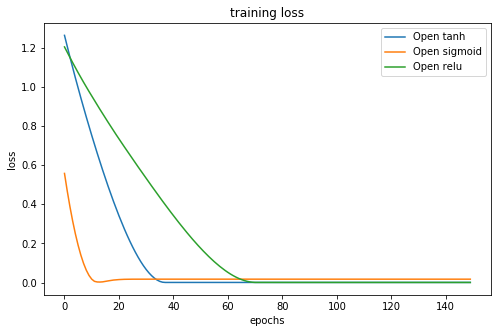

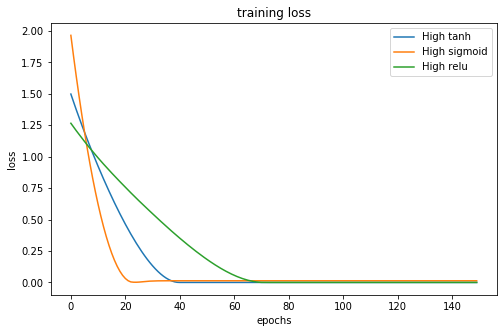

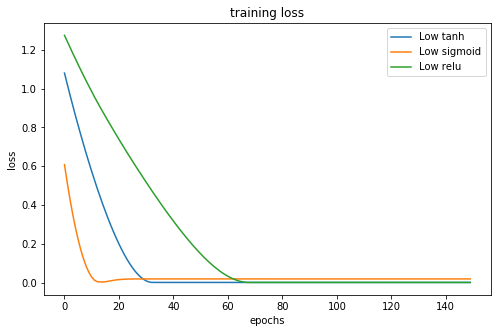

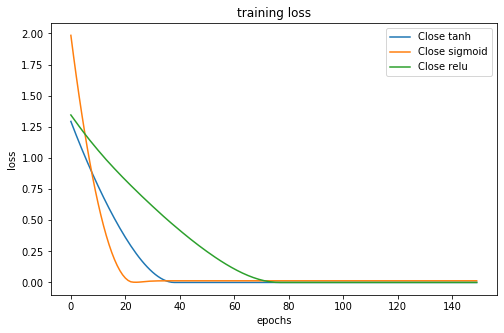

In [63]:
m.plot_loss(mode="val_loss")

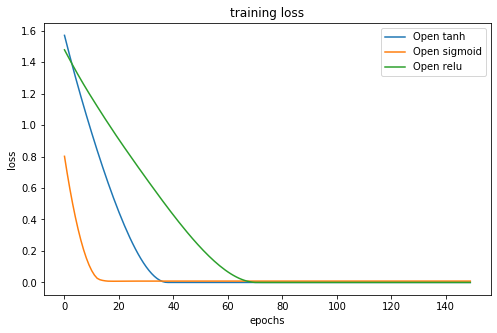

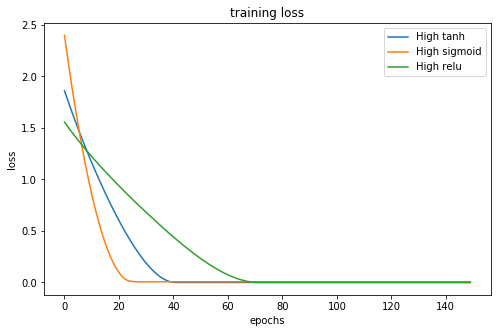

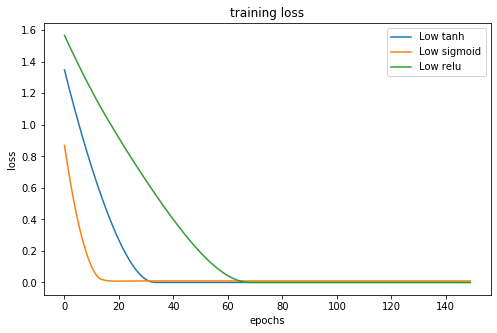

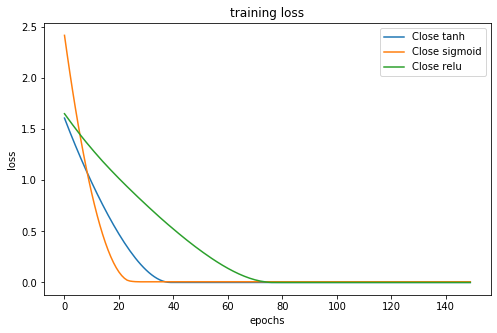

In [64]:
m.plot_loss(mode="loss")

### prediction on test set all model

In [65]:
# #2018.09.26 22:17:11.238	oneCandle EURUSDmicro,H4: 1.17398000,1.17570000,1.17252000,1.17510000

openVal  = m.prediction['Open']['tanh']
closeVal = m.prediction['Close']['tanh']
highVal  = m.prediction['High']['tanh']
lowVal   = m.prediction['Low']['tanh']

print('Open Value',  openVal.shape)
print('Low Value',   lowVal.shape)
print('High Value',  highVal.shape)
print('Close Value', closeVal.shape)

Open Value (4031, 1)
Low Value (4031, 1)
High Value (4031, 1)
Close Value (4031, 1)


### ground truth for all models

In [66]:
print(candletest.shape)
candtt = candletest.reshape(candletest.shape[0], 4)
print(candletest.shape)
actualOpen = candtt[:,0]
actualHigh = candtt[:,1]
actualLow = candtt[:,2]
actualClose = candtt[:,3]

print('Open Value',  actualOpen.shape)
print('Low Value',   actualLow.shape)
print('High Value',  actualHigh.shape)
print('Close Value', actualClose.shape)

(4031, 1, 4)
(4031, 1, 4)
Open Value (4031,)
Low Value (4031,)
High Value (4031,)
Close Value (4031,)


####  saving Ground truth for future use

In [67]:
fn = '../Data/Ground_truth.csv'
df = pd.DataFrame()
df["Open"]  = actualOpen
df["High"]  = actualHigh
df["Low"]   = actualLow
df["Close"] = actualClose
df.to_csv(fn)

### plot groud truth vs prediction

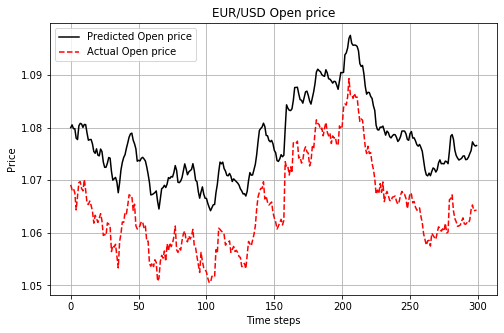

In [68]:
plt.figure(figsize=(8,5))
plt.plot(range(300), openVal[1500:1800],'k-', label = 'Predicted Open price');
plt.plot(range(300),yopentest[1500:1800],'r--', label = 'Actual Open price')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('EUR/USD Open price')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()

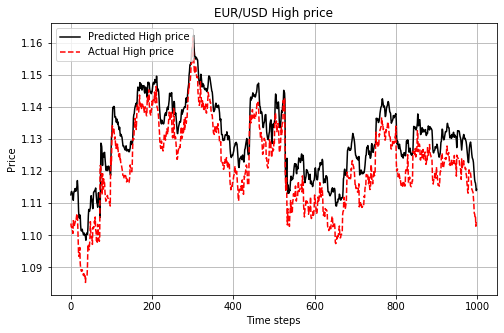

In [69]:
plt.figure(figsize=(8,5))
plt.plot(range(1000), highVal[:1000],'k-', label = 'Predicted High price');
plt.plot(range(1000),yhightest[:1000],'r--', label = 'Actual High price')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('EUR/USD High price')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()

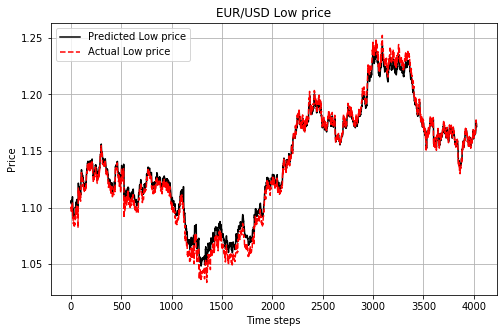

In [70]:
plt.figure(figsize=(8,5))
plt.plot(range(actualOpen.shape[0]-1), lowVal[:len(lowVal)-1],'k-', label = 'Predicted Low price');
plt.plot(range(actualOpen.shape[0]-1),ylowtest[:len(ylowtest)-1],'r--', label = 'Actual Low price')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('EUR/USD Low price')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()

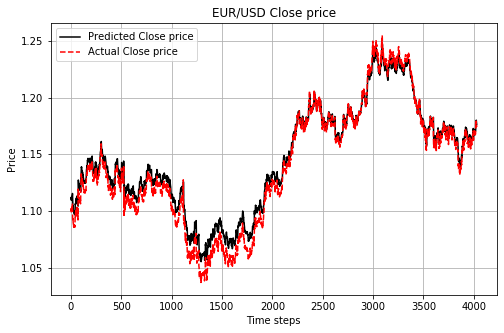

In [71]:
plt.figure(figsize=(8,5))
plt.plot(range(actualOpen.shape[0]-1),  closeVal[:len(closeVal)-1],'k-', label = 'Predicted Close price');
plt.plot(range(actualOpen.shape[0]-1), yclosetest[:len(yclosetest)-1],'r--', label = 'Actual Close price')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('EUR/USD Close price')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()

### saving prediction

In [74]:
openV  = openVal.reshape(openVal.shape[0])
highV  = highVal.reshape(highVal.shape[0])
lowV   = lowVal.reshape(lowVal.shape[0])
closeV = closeVal.reshape(closeVal.shape[0])

fn = '../Data/multi_LSTM_tanh.csv'
df = pd.DataFrame()
df["Open"]  = openV
df["High"]  = highV
df["Low"]   = lowV
df["Close"] = closeV
df.to_csv(fn)

In [75]:
openVal_sig  = m.prediction['Open']['sigmoid'].reshape(openVal.shape[0])
highVal_sig  = m.prediction['High']['sigmoid'].reshape(openVal.shape[0])
lowVal_sig   = m.prediction['Low']['sigmoid'].reshape(openVal.shape[0])
closeVal_sig = m.prediction['Close']['sigmoid'].reshape(openVal.shape[0])


fn = '../Data/multi_LSTM_sigmoid.csv'
df = pd.DataFrame()
df["Open"]  = openVal_sig
df["High"]  = highVal_sig
df["Low"]   = lowVal_sig
df["Close"] = closeVal_sig
df.to_csv(fn)

In [76]:
openVal_relu  = m.prediction['Open']['relu'].reshape(openVal.shape[0])
highVal_relu  = m.prediction['High']['relu'].reshape(openVal.shape[0])
lowVal_relu   = m.prediction['Low']['relu'].reshape(openVal.shape[0])
closeVal_relu = m.prediction['Close']['relu'].reshape(openVal.shape[0])


fn = '../Data/multi_LSTM_relu.csv'
df = pd.DataFrame()
df["Open"]  = openVal_relu
df["High"]  = highVal_relu
df["Low"]   = lowVal_relu
df["Close"] = closeVal_relu
df.to_csv(fn)

### saving all models

In [73]:
# modelFolder = '../Models/'
# openm.save(modelFolder+'open_model.h5')
# closem.save(modelFolder+'close_model.h5')
# highm.save(modelFolder+'high_model.h5')
# lowm.save(modelFolder+'low_model.h5')